In [17]:
import os

project_dir = '/content/drive/MyDrive/supply_chain_project'
os.makedirs(project_dir, exist_ok=True)

subfolders = ['data', 'notebooks', 'models', 'dashboard']
for folder in subfolders:
    os.makedirs(os.path.join(project_dir, folder), exist_ok=True)

print("Folder structure created successfully in Google Drive!")

Folder structure created successfully in Google Drive!


In [18]:
from google.colab import files

print("Please upload your supply_chain_data.csv file:")
uploaded = files.upload()

filename = next(iter(uploaded))
file_path = os.path.join(project_dir, 'data', filename)

with open(file_path, 'wb') as f:
    f.write(uploaded[filename])

print(f"File '{filename}' saved to /data/")

Please upload your supply_chain_data.csv file:


Saving supply_chain_data.csv to supply_chain_data (2).csv
File 'supply_chain_data (2).csv' saved to /data/


In [19]:
import pandas as pd

column_names = [
    "Product type", "SKU", "Price", "Availability", "Number of products sold",
    "Revenue generated", "Customer demographics", "Stock levels", "Lead times",
    "Order quantities", "Shipping times", "Shipping carriers", "Shipping costs",
    "Supplier name", "Location", "Lead time", "Production volumes",
    "Manufacturing lead time", "Manufacturing costs", "Inspection results",
    "Defect rates", "Transportation modes", "Routes", "Costs"
]

df = pd.read_csv(file_path, header=None)
df.columns = column_names
df = df.iloc[1:]

numeric_cols = [
    "Price", "Availability", "Number of products sold", "Revenue generated",
    "Stock levels", "Lead times", "Order quantities", "Shipping times",
    "Shipping costs", "Production volumes", "Manufacturing lead time",
    "Manufacturing costs", "Defect rates", "Costs"
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df.fillna(0, inplace=True)
print("Data cleaned successfully!")

Data cleaned successfully!


In [20]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("Data encoded successfully!")

Data encoded successfully!


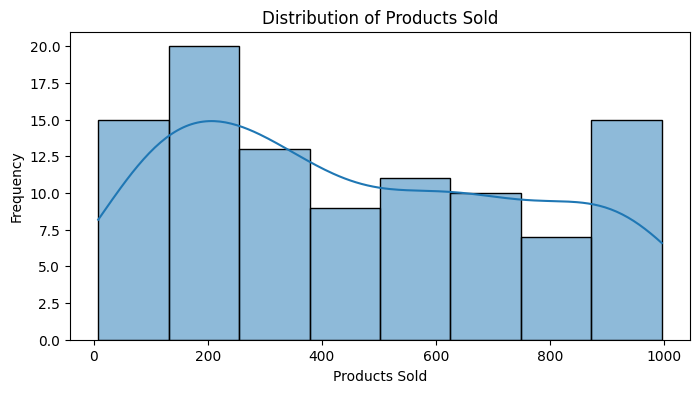

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.histplot(df['Number of products sold'], kde=True)
plt.title('Distribution of Products Sold')
plt.xlabel('Products Sold')
plt.ylabel('Frequency')
plt.show()

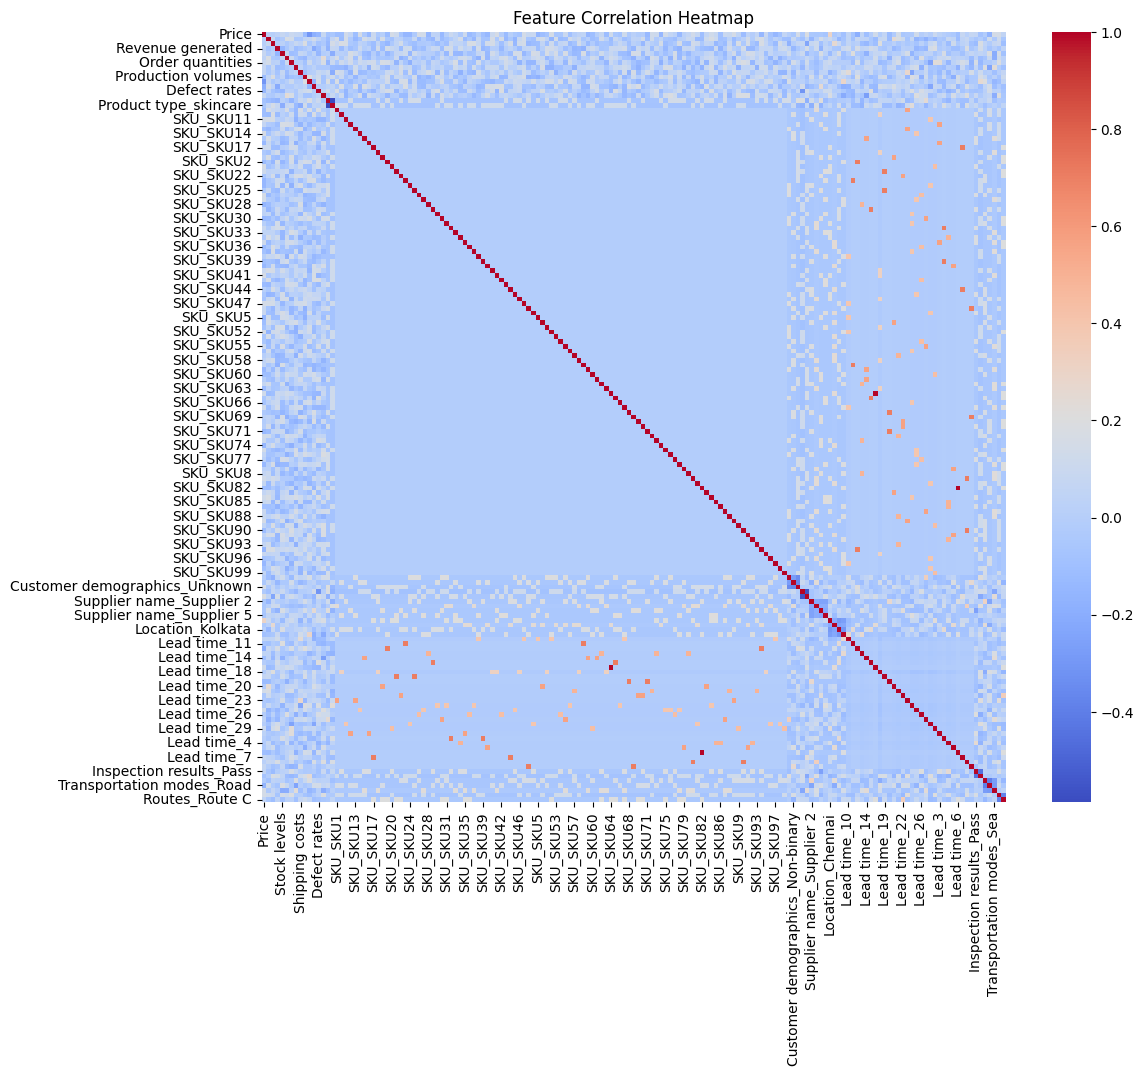

In [22]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

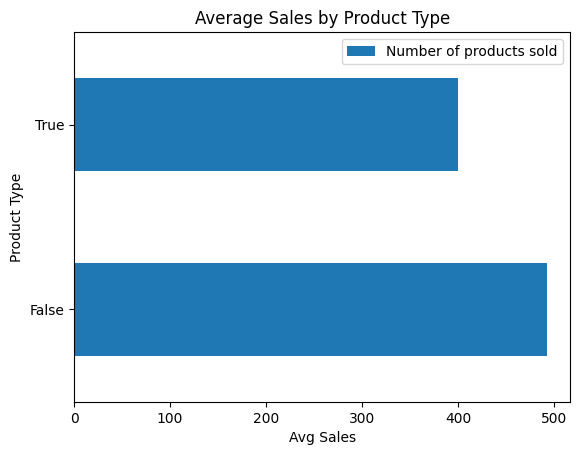

In [23]:
product_sales = df.groupby('Product type_haircare')['Number of products sold'].mean().reset_index()
product_sales.plot(kind='barh', x='Product type_haircare', y='Number of products sold')
plt.title('Average Sales by Product Type')
plt.xlabel('Avg Sales')
plt.ylabel('Product Type')
plt.show()

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = "Number of products sold"
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")

Features scaled successfully!


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define improved model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])

# Compile with better optimizer and learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae', 'mse']
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    os.path.join(project_dir, 'models', 'best_model.keras'),
    monitor='val_loss',
    save_best_only=True
)

print("Callbacks defined correctly.")



Callbacks defined correctly.


In [39]:
# Train model
history = model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint],
    verbose=0
)

# Evaluate
loss, mae, mse = model.evaluate(X_test_scaled, y_test, verbose=0)
rmse = np.sqrt(mse)

print(f"\nFinal Evaluation Results:")
print(f"  - Loss (MSE): {mse:.2f}")
print(f"  - MAE: {mae:.2f}")
print(f"  - RMSE: {rmse:.2f}")


Final Evaluation Results:
  - Loss (MSE): 140417.86
  - MAE: 319.32
  - RMSE: 374.72


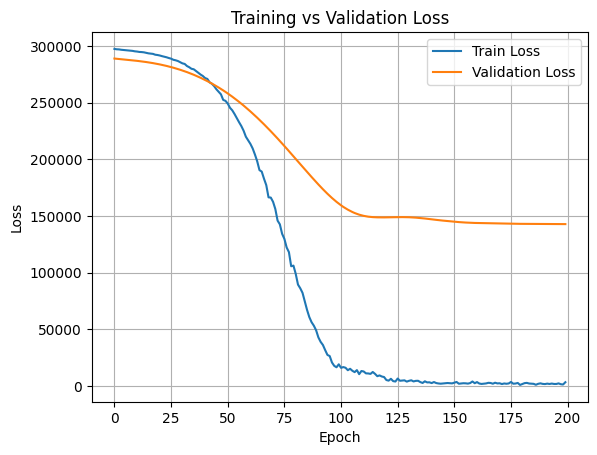

In [41]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


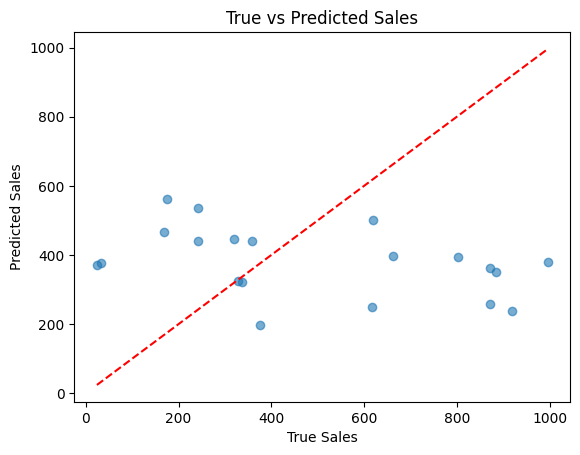

In [42]:
import numpy as np

test_pred = model.predict(X_test_scaled).flatten()

# Plot true vs predicted sales
plt.scatter(y_test, test_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
plt.title("True vs Predicted Sales")
plt.xlabel("True Sales")
plt.ylabel("Predicted Sales")
plt.show()

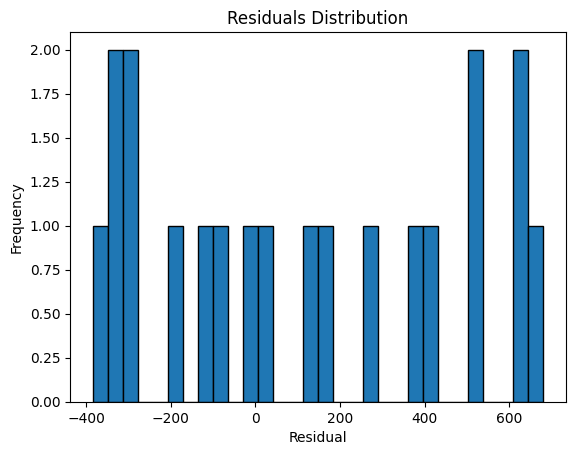

In [43]:
# Residuals = Actual - Predicted
residuals = y_test.values - test_pred

# Distribution of residuals
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Residuals Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━

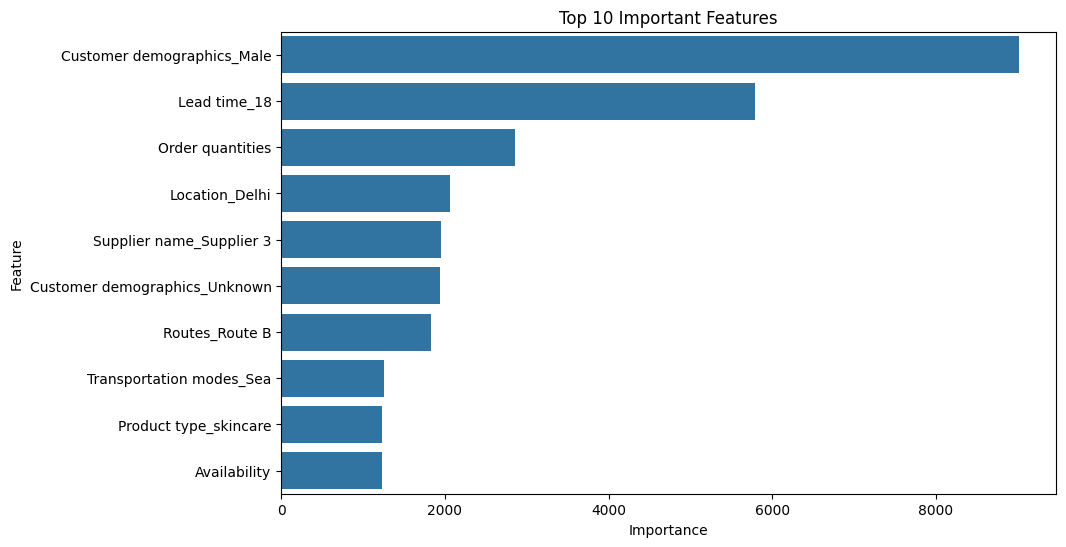

In [45]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance with explicit scoring
result = permutation_importance(
    model,
    X_test_scaled,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='neg_mean_squared_error'
)

# Create DataFrame of importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
})

# Sort and plot
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title("Top 10 Important Features")
plt.show()

In [46]:
# Save final model in modern format
model.save(os.path.join(project_dir, 'models', 'demand_forecasting_model_improved.keras'))
print("Model saved in modern Keras format: demand_forecasting_model_improved.keras")

Model saved in modern Keras format: demand_forecasting_model_improved.keras


In [47]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model(os.path.join(project_dir, 'models', 'demand_forecasting_model_improved.keras'))

# Test prediction
new_prediction = loaded_model.predict(X_test_scaled[:1])
print(f"Reloaded model! Example prediction: {new_prediction[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Reloaded model! Example prediction: 397.02


In [48]:
# Show sample predictions
sample_data = X_test_scaled[:5]
predicted_sales = model.predict(sample_data).flatten()

print("\nSample Predictions:")
for i, pred in enumerate(predicted_sales):
    print(f"Prediction {i+1}: ${pred:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step

Sample Predictions:
Prediction 1: $397.02
Prediction 2: $536.36
Prediction 3: $377.95
Prediction 4: $371.46
Prediction 5: $238.44


In [49]:
# Save predictions to file
results = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': test_pred
})
results.to_csv(os.path.join(project_dir, 'dashboard', 'predictions.csv'), index=False)

print("Predictions saved to /dashboard/predictions.csv")

Predictions saved to /dashboard/predictions.csv


In [50]:
def predict_sales(input_data):
    """
    Predict number of products sold based on input data
    Args:
        input_data (np.array): Scaled input features
    Returns:
        float: Predicted number of products sold
    """
    prediction = model.predict(input_data, verbose=0)
    return prediction[0][0]

# Example usage
example_input = X_test_scaled[:1]
predicted_value = predict_sales(example_input)
print(f"\nPredicted Sales: {predicted_value:.2f}")


Predicted Sales: 397.02


In [52]:
predictions_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': test_pred
})
predictions_df.to_csv(os.path.join(project_dir, 'dashboard', 'predictions.csv'), index=False)

print("Predictions saved to /dashboard/predictions.csv")

Predictions saved to /dashboard/predictions.csv


In [51]:
!pip install -q pandasql
from pandasql import sqldf

try:
    pysqldf = lambda q: sqldf(q, globals())
    query = """
    SELECT Location_Chennai, AVG(`Number of products sold`) AS Avg_Sales
    FROM df
    GROUP BY Location_Chennai
    ORDER BY Avg_Sales DESC
    """
    result = pysqldf(query)
    print("\nAverage Sales by Location (SQL Query):")
    print(result.head())
except Exception as e:
    print("SQL Error:", str(e))


Average Sales by Location (SQL Query):
   Location_Chennai  Avg_Sales
0                 0   466.6375
1                 1   438.4000


In [53]:
dashboard_code = """
import streamlit as st
import pandas as pd
import plotly.express as px

st.title("Supply Chain Analytics Dashboard")

# Load predictions
df = pd.read_csv('predictions.csv')

# Section 1: Raw Predictions
st.header("Predicted vs Actual Sales")
st.dataframe(df.head())

# Section 2: Scatter Plot
st.header("True vs Predicted Sales")
fig = px.scatter(df, x='Actual', y='Predicted', trendline='ols')
st.plotly_chart(fig)

# Section 3: Residuals
st.header("Residuals Distribution")
df['Residuals'] = df['Actual'] - df['Predicted']
fig = px.histogram(df, x='Residuals', nbins=30)
st.plotly_chart(fig)
"""

dashboard_path = os.path.join(project_dir, 'dashboard', 'app.py')
with open(dashboard_path, 'w') as f:
    f.write(dashboard_code)

print("Dashboard app created at /dashboard/app.py")

Dashboard app created at /dashboard/app.py


In [54]:
# To run locally :  streamlit run app.py

In [55]:
readme_content = """
# Supply Chain Demand Forecasting with Machine Learning

## Overview
This project predicts product sales using machine learning to help optimize inventory and reduce waste in a fashion & beauty startup.

### Features
- Data preprocessing using Pandas
- Feature engineering with date parsing
- Neural Network model using TensorFlow/Keras
- Interactive dashboard with Streamlit

### Technologies Used
- Python
- SQL
- TensorFlow
- Streamlit
"""

readme_path = os.path.join(project_dir, 'README.md')
with open(readme_path, 'w') as f:
    f.write(readme_content)

print("README.md created.")

README.md created.


In [56]:
requirements = """
pandas
numpy
matplotlib
seaborn
scikit-learn
tensorflow
streamlit
pandasql
joblib
"""

requirements_path = os.path.join(project_dir, 'requirements.txt')
with open(requirements_path, 'w') as f:
    f.write(requirements)

print("requirements.txt created.")

requirements.txt created.


In [57]:
!cd /content/drive/MyDrive && zip -r supply_chain_project.zip supply_chain_project
print("ZIP file created. You can find it in your Google Drive.")

  adding: supply_chain_project/ (stored 0%)
  adding: supply_chain_project/data/ (stored 0%)
  adding: supply_chain_project/data/supply_chain_data (2).csv (deflated 57%)
  adding: supply_chain_project/notebooks/ (stored 0%)
  adding: supply_chain_project/models/ (stored 0%)
  adding: supply_chain_project/models/best_model.keras (deflated 20%)
  adding: supply_chain_project/models/demand_forecasting_model_improved.keras (deflated 20%)
  adding: supply_chain_project/dashboard/ (stored 0%)
  adding: supply_chain_project/dashboard/predictions.csv (deflated 38%)
  adding: supply_chain_project/dashboard/app.py (deflated 47%)
  adding: supply_chain_project/README.md (deflated 38%)
  adding: supply_chain_project/requirements.txt (deflated 16%)
ZIP file created. You can find it in your Google Drive.
